In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autograd.numpy import log, sqrt, sin, cos, exp, pi, prod
from autograd.numpy.random import normal, uniform
import os
from scipy import stats
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

In [ ]:
# import data
import pickle
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/'

f = open(PATH + "result/popCSGLD_samples.txt", "rb")
pop_csgld_epoch, pop_csgld_x = pickle.load(f)
f.close()
f = open(PATH + "SGLD_result/pop_SGLD_samples.txt", "rb")
pop_sgld_epoch, pop_sgld_x = pickle.load(f)
f.close()
f = open(PATH + "reSGLD_result/pop_reSGLD_samples_var30.txt", "rb")
resgld_epoch, resgld_x = pickle.load(f)
f.close()
f = open(PATH + "cyclicalSGLD_result/cyclicalSGLD_samples.txt", "rb")
cyclicalsgld_epoch, cyclicalsgld_x = pickle.load(f)
f.close()
f = open(PATH + "result/CSGLD/CSGLD_samples.txt", "rb")
csgld_epoch, csgld_x = pickle.load(f)
f.close()

In [ ]:
import pickle
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/'
f = open(PATH + "SPOS_result/population_SPOS_samples.txt", "rb")
pspos_x = pickle.load(f)
f.close()
f = open(PATH + "SVGD_result/population_SVGD_samples.txt", "rb")
psvgd_x = pickle.load(f)
f.close()
f = open(PATH + "SPOS_result/single_SPOS_samples.txt", "rb")
spos_x = pickle.load(f)
f.close()
f = open(PATH + "SVGD_result/single_SVGD_samples.txt", "rb")
svgd_x = pickle.load(f)
f.close()

In [ ]:
def mixture(x):
    energy = ((x[0]**2 + x[1]**2)/10 - (cos(2.0*pi*x[0]) + cos(2.0*pi*x[1]))) / 0.5 # 2
    regularizer = ((x[0]**2 + x[1]**2) > 20) * ((x[0]**2 + x[1]**2) - 20)
    return energy + regularizer

def mixture_expand(x, y): return mixture([x, y])
def function_plot(x, y): return np.exp(-mixture([x, y]))

lower, upper = -2.5, 2.5
axis_x = np.linspace(lower, upper, 500)
axis_y = np.linspace(lower, upper, 500)
axis_X, axis_Y = np.meshgrid(axis_x, axis_y)

energy_grid = mixture_expand(axis_X, axis_Y)
prob_grid = function_plot(axis_X, axis_Y)
pmax = np.max(prob_grid)

generate samples from the true density

In [ ]:
# # generate samples from the true density
# def rejection_sampler(p,xbounds,pmax):
#     while True:
#         x = [np.random.rand(1)*(xbounds[1]-xbounds[0])+xbounds[0] for _ in range(2)]
#         y = np.random.rand(1)*pmax
#         if y<=p(x[0], x[1]):
#             return x

In [ ]:
# true_samples = []
# for iter in range(50000):
#     sample = rejection_sampler(function_plot,[lower, upper],pmax)
#     if sample:
#         true_samples.append(sample)


In [ ]:
# true_samples = np.array(true_samples)
# true_samples = true_samples.reshape((-1,2))
# import pickle
# f = open(PATH + "simulation_figures/true_samples.txt", 'wb')
# pickle.dump(true_samples, f)
# f.close()

In [ ]:
f = open(PATH + "simulation_figures/true_samples.txt", 'rb')
true_samples = pickle.load(f)
f.close()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


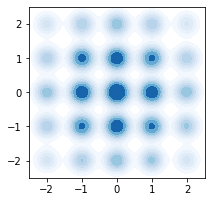

In [ ]:
# plot true samples
warm_sample = 50
split_ = 1
fig = plt.figure(figsize=(3.15, 3.15))
ax = sns.kdeplot(true_samples[:,0], true_samples[:,1],  cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
plt.savefig('anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/simulation_figures/true_samples.png')

Calculate the KL divergence

In [ ]:
def KLdivergence(x, y):
    """Compute the Kullback-Leibler divergence between two multivariate samples.
    Parameters
    ----------
    x : 2D array (n,d)
      Samples from distribution P, which typically represents the true
      distribution.
    y : 2D array (m,d)
      Samples from distribution Q, which typically represents the approximate
      distribution.
    Returns
    -------
    out : float
      The estimated Kullback-Leibler divergence D(P||Q).
    References
    ----------
    Pérez-Cruz, F. Kullback-Leibler divergence estimation of
  continuous distributions IEEE International Symposium on Information
  Theory, 2008.
    """
    from scipy.spatial import cKDTree as KDTree

    # Check the dimensions are consistent
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)

    n,d = x.shape
    m,dy = y.shape

    assert(d == dy)


    # Build a KD tree representation of the samples and find the nearest neighbour
    # of each point in x.
    xtree = KDTree(x)
    ytree = KDTree(y)

    # Get the first two nearest neighbours for x, since the closest one is the
    # sample itself.
    r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
    s = ytree.query(x, k=1, eps=.01, p=2)[0]

    # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
    # on the first term of the right hand side.
    return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

In [ ]:
cyclicalsgld_kl = []
cyclicalsgld_epochs = []
for repeat in range(20):
    cyclicalsgld_path = []
    cyclicalsgld_epoch_path = []  
    for i in range(100, cyclicalsgld_x[repeat].shape[0]):
        cyclicalsgld_path.append(KLdivergence(true_samples, cyclicalsgld_x[repeat][:i,:]))
        cyclicalsgld_epoch_path.append(cyclicalsgld_epoch[repeat][i])
    cyclicalsgld_kl.append(cyclicalsgld_path)
    cyclicalsgld_epochs.append(cyclicalsgld_epoch_path)

In [ ]:
PATH = "anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/simulation_figures/"
import pickle
f = open(PATH + 'cyclicalsgld_kl.txt', 'wb')
pickle.dump([cyclicalsgld_epochs, cyclicalsgld_kl], f)
f.close()

In [ ]:
psgld_kl = []
psgld_epochs = []
for repeat in range(20):
    psgld_path = []
    psgld_epoch_path = []  
    for i in range(100, pop_sgld_x[repeat].shape[0]):
        psgld_path.append(KLdivergence(true_samples, pop_sgld_x[repeat][:i,:]))
        psgld_epoch_path.append(pop_sgld_epoch[repeat][i])
    psgld_kl.append(psgld_path)
    psgld_epochs.append(psgld_epoch_path)

In [ ]:
PATH = "anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/simulation_figures/"
import pickle
f = open(PATH + 'psgld_kl.txt', 'wb')
pickle.dump([psgld_epochs, psgld_kl], f)
f.close()

In [ ]:
resgld_kl = []
resgld_epochs = []
for repeat in range(20):
    resgld_path = []
    resgld_epoch_path = []  
    for i in range(100, resgld_x[repeat].shape[0]):
        resgld_path.append(KLdivergence(true_samples, resgld_x[repeat][:i,:]))
        resgld_epoch_path.append(resgld_epoch[repeat][i])
    resgld_kl.append(resgld_path)
    resgld_epochs.append(resgld_epoch_path)

In [ ]:
PATH = "anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/simulation_figures/"
import pickle
f = open(PATH + 'resgld_kl.txt', 'wb')
pickle.dump([resgld_epochs, resgld_kl], f)
f.close()

In [ ]:
pcsgld_kl = []
pcsgld_epochs = []
for repeat in range(20):
    pcsgld_path = []
    pcsgld_epoch_path = []  
    for i in range(100, pop_csgld_x[repeat].shape[0]):
        pcsgld_path.append(KLdivergence(true_samples, pop_csgld_x[repeat][:i,:]))
        pcsgld_epoch_path.append(pop_csgld_epoch[repeat][i])
    pcsgld_kl.append(pcsgld_path)
    pcsgld_epochs.append(pcsgld_epoch_path)

In [ ]:
PATH = "anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/simulation_figures/"
import pickle
f = open(PATH + 'pcsgld_kl.txt', 'wb')
pickle.dump([pcsgld_epochs, pcsgld_kl], f)
f.close()

In [ ]:
csgld_kl = []
csgld_epochs = []
for repeat in range(20):
    csgld_path = []
    csgld_epoch_path = []  
    for i in range(100, csgld_x[repeat].shape[0]):
        csgld_path.append(KLdivergence(true_samples, csgld_x[repeat][:i,:]))
        csgld_epoch_path.append(csgld_epoch[repeat][i])
    csgld_kl.append(csgld_path)
    csgld_epochs.append(csgld_epoch_path)

In [ ]:
PATH = "anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/simulation_figures/"
import pickle
f = open(PATH + 'csgld_kl.txt', 'wb')
pickle.dump([csgld_epochs, csgld_kl], f)
f.close()

# Plot the KL divergence vs time step

## calculate the confidence interval

In [ ]:
# load the data
PATH = "anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/simulation_figures/"
import pickle
f = open(PATH + 'psgld_kl.txt', 'rb')
psgld_epochs, psgld_kl = pickle.load(f)
f.close()
f = open(PATH + 'cycSGLD_kl.txt', 'rb')
cyclicalsgld_epochs, cyclicalsgld_kl = pickle.load(f)
f.close()
f = open(PATH + 'resgld_kl_var25.txt', 'rb')
resgld_epochs, resgld_kl = pickle.load(f)
f.close()
f = open(PATH + 'pcsgld_kl.txt', 'rb')
pcsgld_epochs, pcsgld_kl = pickle.load(f)
f.close()
f = open(PATH + 'csgld_kl.txt', 'rb')
csgld_epochs, csgld_kl = pickle.load(f)
f.close()

In [ ]:
cyclicalsgld_kl_array = np.array(cyclicalsgld_kl)
cyclicalsgld_epoch_array = np.array(cyclicalsgld_epochs)

csgld_epoch_array = np.array(csgld_epochs)
csgld_kl_array = np.array(csgld_kl)

In [ ]:
def process_data(kl, epochs):
    # compute the average of five chains at each iteration
    final_kl_avg = []
    final_epoch = []
    for i in range(20):
        tmp = []
        kl_avg, epoch_uniq = [], []
        for j in range(len(kl[i])):
            if not epoch_uniq:
                epoch_uniq.append(epochs[i][j])
                tmp.append(kl[i][j])
            elif epoch_uniq[-1] == epochs[i][j]:
                tmp.append(kl[i][j])
            else:
                kl_avg.append(np.mean(tmp))
                tmp = [kl[i][j]]
                epoch_uniq.append(epochs[i][j])
        kl_avg.append(np.mean(tmp))
        final_kl_avg.append(kl_avg)
        final_epoch.append(epoch_uniq)
    
    # compute the mu and sd of the 20 trials
    mu, sd, epoch_uniq = [], [], []
    for i in range(final_epoch[0][-1], -1, -20):
        tmp = []
        for j in range(20):
            if not final_epoch[j]:
                continue
            if final_epoch[j][-1] == i:
                tmp.append(final_kl_avg[j].pop())
                final_epoch[j].pop()
        if tmp:
          mu.append(np.mean(tmp))
          sd.append(np.std(tmp)/np.sqrt(len(tmp)))
          epoch_uniq.append(i)
    return np.array(mu[::-1]), np.array(sd[::-1]), np.array(epoch_uniq[::-1])

In [ ]:
psgld_mu, psgld_sd, psgld_epoch_uniq = process_data(psgld_kl, psgld_epochs)
resgld_mu, resgld_sd, resgld_epoch_uniq = process_data(resgld_kl, resgld_epochs)
pcsgld_mu, pcsgld_sd, pcsgld_epoch_uniq = process_data(pcsgld_kl, pcsgld_epochs)

In [ ]:
csgld_mu, csgld_sd, csgld_epoch_uniq = process_data(csgld_kl, csgld_epochs)
csgld_epoch_uniq = [csgld_epoch_uniq[i] / 5 for i in range(0, len(csgld_epoch_uniq))]

In [ ]:
cyclicalsgld_sd = np.array([np.std(cyclicalsgld_kl_array[:,i]) for i in range(0, cyclicalsgld_kl_array.shape[1])]) / np.sqrt(20)
cyclicalsgld_mu = np.array([np.mean(cyclicalsgld_kl_array[:,i]) for i in range(0, cyclicalsgld_kl_array.shape[1])]) 
cyclicalsgld_epoch_uniq = [cyclicalsgld_epochs[0][i] / 5 for i in range(0, len(cyclicalsgld_epochs[0]))]

In [ ]:
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 22,
}

font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 22,
}


figsize = 9, 8
plt.style.use('ggplot')
figure, ax = plt.subplots(figsize=figsize)
plt.grid("darkgrid")

plt.plot(csgld_epoch_uniq, csgld_mu, label="CSGLD xT5", linewidth = 2, alpha=0.5, color="purple")
plt.fill_between(csgld_epoch_uniq, csgld_mu-csgld_sd, csgld_mu+csgld_sd,
                  alpha = 0.3, color="purple")
plt.plot(cyclicalsgld_epoch_uniq, cyclicalsgld_mu, label="cycSGLD xT5", linewidth = 2, alpha=0.5, color="purple")
plt.fill_between(cyclicalsgld_epoch_uniq, cyclicalsgld_mu-cyclicalsgld_sd, cyclicalsgld_mu+cyclicalsgld_sd,
                  alpha = 0.3, color="purple")
plt.plot(psgld_epoch_uniq, psgld_mu, label="SGLD xP5", linewidth = 2, alpha=0.5, color="red")
plt.fill_between(psgld_epoch_uniq, psgld_mu-psgld_sd, psgld_mu+psgld_sd,
                  alpha = 0.3, color="red")
plt.plot(resgld_epoch_uniq, resgld_mu, label="reSGLD xP5", linewidth = 2, alpha=0.6, color="steelblue")
plt.fill_between(resgld_epoch_uniq, resgld_mu-resgld_sd, resgld_mu+resgld_sd,
                  alpha = 0.5, color="steelblue")
plt.plot(pcsgld_epoch_uniq, pcsgld_mu, label="ICSGLD xP5", linewidth = 2, alpha=0.6, color="orange")
plt.fill_between(pcsgld_epoch_uniq, pcsgld_mu-pcsgld_sd, pcsgld_mu+pcsgld_sd,
                  alpha = 0.4, color="orange")
plt.tick_params(labelsize=22, colors="black")
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.subplots_adjust(left = 0.15,bottom=0.128)

plt.legend(prop=font1)
plt.ylabel("KL divergence", font2, color="black")
plt.xlabel("Steps", font2, color="black")
plt.savefig(PATH + 'kl_vs_time_step.png')
plt.close()

# SVGD & SPOS

In [ ]:
psvgd_path = []
svgd_path = []
pspos_path = []
spos_path = []
pspos_x = np.array(pspos_x).reshape((-1,2))
psvgd_x = np.array(psvgd_x).reshape((-1,2))
for i in range(100, len(psvgd_x)):
    psvgd_path.append(KLdivergence(true_samples, psvgd_x[i]))
    pspos_path.append(KLdivergence(true_samples, pspos_x[i]))



In [ ]:
for i in range(100, len(svgd_x)):
    svgd_path.append(KLdivergence(true_samples, svgd_x[i]))
    spos_path.append(KLdivergence(true_samples, spos_x[i]))

PATH = "anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/simulation_figures/"
import pickle
f = open(PATH + 'particles_path.txt', 'wb')
pickle.dump([psvgd_path, svgd_path, pspos_path, spos_path], f)
f.close()

In [ ]:
x =  np.arange(100, 4e5, 20)
plt.plot(x, pcsgld_path, label="pcsgld")
plt.plot(x, psgld_path, label="psgld")
plt.plot(x, csgld_path, label="csgld")
plt.plot(x, sgld_path, label="sgld")
plt.plot(epoch_path[99:], cyclicalsgld_path, label="cyclicalsgld")

plt.legend()
plt.ylabel("KL divergence")
plt.xlabel("time steps")